# Satellite Imagery Classification

- objective
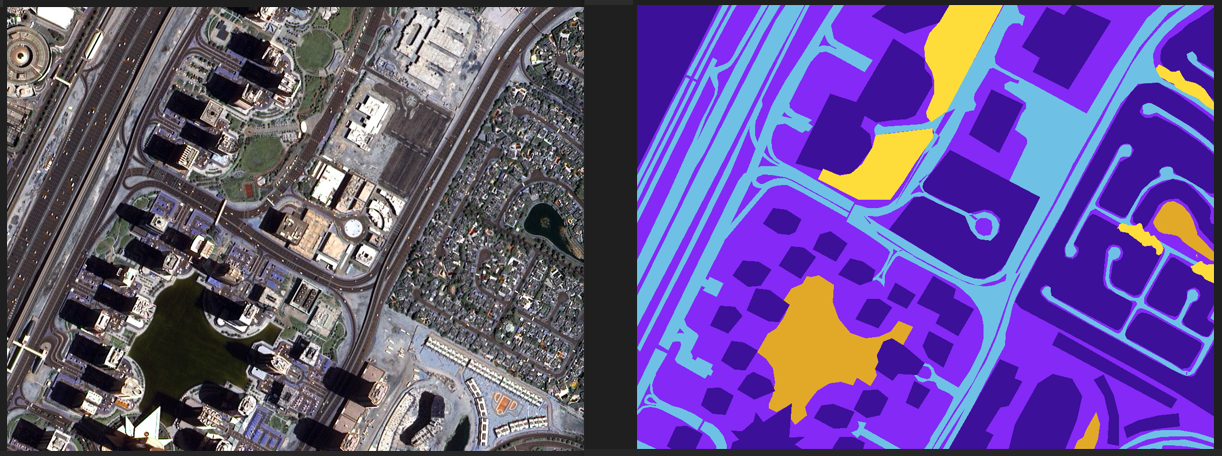
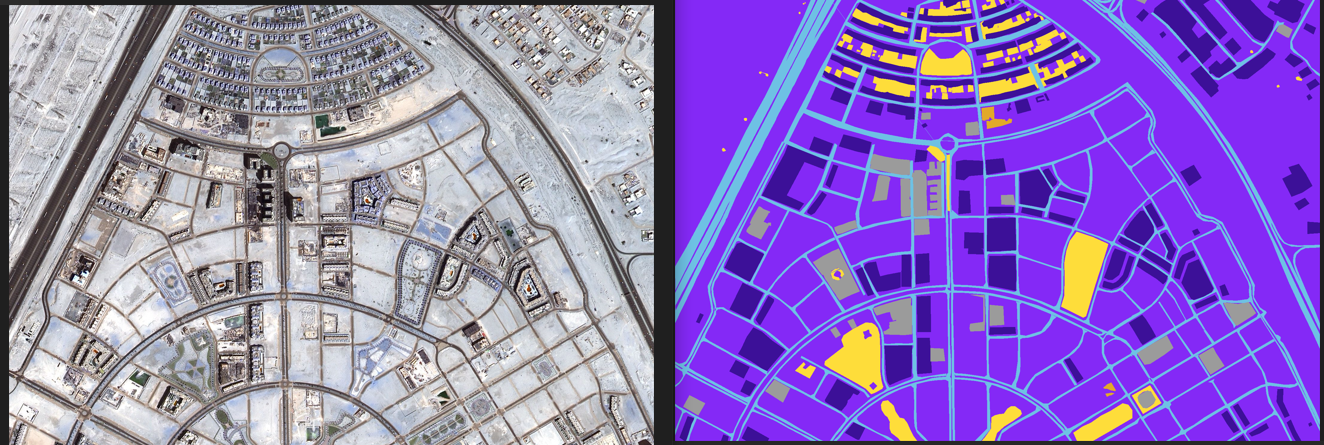

In [9]:
import os
import tensorflow as tf
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

# PART 1 data preprocessing

In [10]:
dataset_root_folder='dataset/'
dataset_name='dubai_dataset'

In [11]:
minmaxscalar=MinMaxScaler()

In [12]:
for path, subdir, files in os.walk(os.path.join(dataset_root_folder,dataset_name)):
    dir_name=path.split(os.path.sep)[-1]
    # print(dir_name)
    if dir_name == 'masks':
        images=os.listdir(path)
        # print(images)
        print(path)
        for i,image_name in enumerate(images):
            if (image_name.endswith('.png')): # mask image
                a=True
                # print(image_name)
    

dataset/dubai_dataset\Tile 1\masks
dataset/dubai_dataset\Tile 2\masks
dataset/dubai_dataset\Tile 3\masks
dataset/dubai_dataset\Tile 4\masks
dataset/dubai_dataset\Tile 5\masks
dataset/dubai_dataset\Tile 6\masks
dataset/dubai_dataset\Tile 7\masks
dataset/dubai_dataset\Tile 8\masks


In [13]:
# define patch size
image_patch_size=256

In [14]:
image=cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 2/images/image_part_001.jpg',1)
image.shape

(544, 509, 3)

In [15]:
image_patches=patchify(image,(image_patch_size,image_patch_size,3),step=image_patch_size)

In [16]:
image_patches.shape

(2, 1, 1, 256, 256, 3)

In [17]:
imagex=image_patches[0,0,:,:]

imagey=minmaxscalar.fit_transform(imagex.reshape(-1,imagex.shape[-1])).reshape(imagex.shape)
imagey[0].shape

(256, 256, 3)

In [18]:
print(type(image))

<class 'numpy.ndarray'>


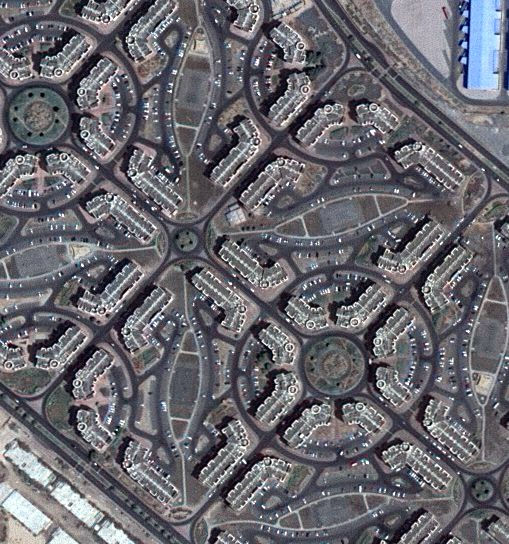

In [19]:
Image.fromarray(image)

In [20]:
(image.shape[0]//image_patch_size)*image_patch_size

512

# each image is of different shape

In [21]:
image_dataset=[]
mask_dataset=[]
 #png #jpg
for image_type in ['images','masks']:    #masks #images
    if image_type=='images':
        image_extension='jpg'
    elif image_type=='masks':
        image_extension='png'
    for tile_id in range(1,8):
        for image_id in range(1,20):
            image=cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
            if image is not None:

                if image_type=='masks':
                    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                # print(image.shape)
                size_x=(image.shape[1]//image_patch_size)*image_patch_size
                size_y=(image.shape[0]//image_patch_size)*image_patch_size
                # print('{}----{}-{}'.format(image.shape,size_x,size_y)) # multiples of 256
                image=Image.fromarray(image)
                image=image.crop((0,0,size_x,size_y))
                # print(f'{image.size[0]},{image.size[1]}')
                image=np.array(image)
                patched_images=patchify(image,(image_patch_size,image_patch_size,3),step=image_patch_size)
                # print(patched_images.shape)
                #get individual patched image
                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        if image_type == 'images':
                            individual_patched_image=patched_images[i,j,:,:]
                            # print(individual_patched_image.shape)
                            individual_patched_image=minmaxscalar.fit_transform(individual_patched_image.reshape(-1,individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                            individual_patched_image=individual_patched_image[0]
                            # print(individual_patched_image.shape)
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask=patched_images[i,j,:,:]
                            individual_patched_mask=individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)

In [22]:
image_dataset=np.array(image_dataset)
mask_dataset=np.array(mask_dataset)

In [23]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


# renderning the images

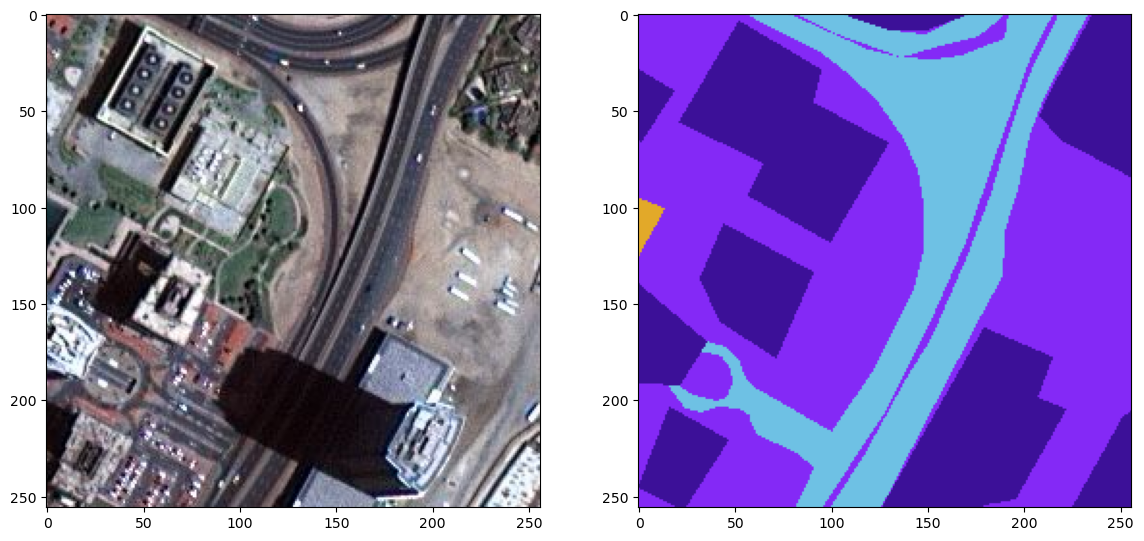

In [24]:
random_image_id=random.randint(0,len(image_dataset))
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

# Mask label processing
- color code to one-Hot encoding transformation
- after each image is transformed into
- 256x256x3 where 3 is RGB color code
- 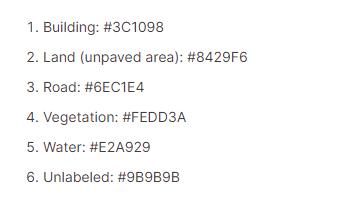

# python code to convert HEX value to RGB

In [25]:
class_building='#3C1098' # blue #green RGB
class_building=class_building.strip('#')
# 3C 10 98
class_building=np.array(tuple(int(class_building[i:i+2],16) for i in (0,2,4)))
print(class_building)

class_land='#8429F6' # purple #light green RGB
class_land=class_land.strip('#')
class_land=np.array(tuple(int(class_land[i:i+2],16) for i in (0,2,4)))
print(class_land)

class_road='#6EC1E4' # light blue #skin RGB
class_road=class_road.strip('#')
class_road=np.array(tuple(int(class_road[i:i+2],16) for i in (0,2,4)))
print(class_road)

class_vegetation='#FEDD3A' # yellow
class_vegetation=class_vegetation.strip('#')
class_vegetation=np.array(tuple(int(class_vegetation[i:i+2],16) for i in (0,2,4)))
print(class_vegetation)

class_water='#E2A929' # gold
class_water=class_water.strip('#')
class_water=np.array(tuple(int(class_water[i:i+2],16) for i in (0,2,4)))
print(class_water)

class_unlabeled='#9B9B9B' # silver
class_unlabeled=class_unlabeled.strip('#')
class_unlabeled=np.array(tuple(int(class_unlabeled[i:i+2],16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [26]:
mask_dataset.shape

(945, 256, 256, 3)

In [27]:
label=individual_patched_mask

In [28]:
def rgb_to_label(label):
    label_segment=np.zeros(label.shape,dtype=np.uint8)
    label_segment[np.all(label == class_water,axis=-1)]=0
    label_segment[np.all(label == class_land,axis=-1)]=1
    label_segment[np.all(label == class_road,axis=-1)]=2
    label_segment[np.all(label == class_building,axis=-1)]=3
    label_segment[np.all(label == class_vegetation,axis=-1)]=4
    label_segment[np.all(label == class_unlabeled,axis=-1)]=5
    label_segment=label_segment[:,:,0]
    return label_segment

In [29]:
# iterate mask dataset
labels=[]
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)
print(len(labels))

945


In [30]:
labels=np.array(labels)

In [31]:
labels[0]

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [32]:
labels=np.expand_dims(labels, axis=3)

In [33]:
# labels[0]

In [34]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


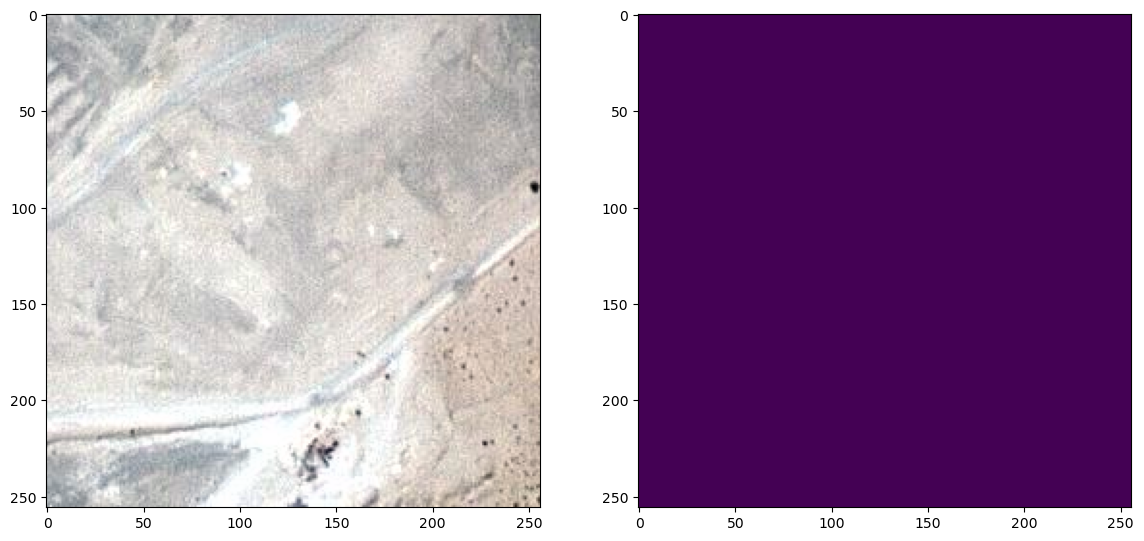

In [35]:
# render output based on labels 
random_image_id=random.randint(0,len(image_dataset))
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
# plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])
# print(labels[random_image_id])

# test and train dataset

In [36]:
master_training_dataset=image_dataset

In [37]:
total_classes=len(np.unique(labels))
total_classes

6

In [38]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [39]:
# create categorical variables 
labels_categorical_dataset=to_categorical(labels,num_classes=total_classes)

In [40]:
labels_categorical_dataset.shape,master_training_dataset.shape

((945, 256, 256, 6), (945, 256, 256, 3))

In [41]:
xtrain,xtest,ytrain,ytest=train_test_split(master_training_dataset,labels_categorical_dataset,test_size=0.15,random_state=100)

In [42]:
xtrain.shape,xtest.shape,ytrain.shape,ytest.shape

((803, 256, 256, 3),
 (142, 256, 256, 3),
 (803, 256, 256, 6),
 (142, 256, 256, 6))

In [43]:
image_height=xtrain.shape[1]
image_width=xtrain.shape[2]
image_channels=xtrain.shape[3]
total_classes=ytrain.shape[3]

In [44]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


# PART 2 - modelling

- define layers
- evaluate layers
- jaccard Index/ intersection over union - evaluation matrics
- loss function - focal loss (cross entropy loss extension)
- diagnostics (plot loss)

In [45]:
from keras.models import Model
from keras.layers import Input,Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [46]:
from keras import backend as K # calculations - tensorflow

## evaluation metrics
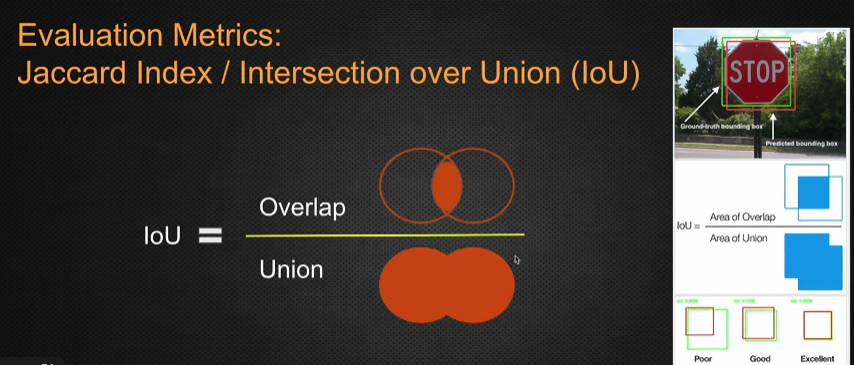

In [47]:
def jaccard_coeff(ytrue, ypred):
    ytrue_flatten=K.flatten(ytrue)
    ypred_flatten=K.flatten(ypred)
    intersection = K.sum(ytrue_flatten * ypred_flatten)
    final_coef_value=(intersection+1.0)/(K.sum(ytrue_flatten)+K.sum(ypred_flatten)-intersection+1.0)
    return final_coef_value

## u net architecture
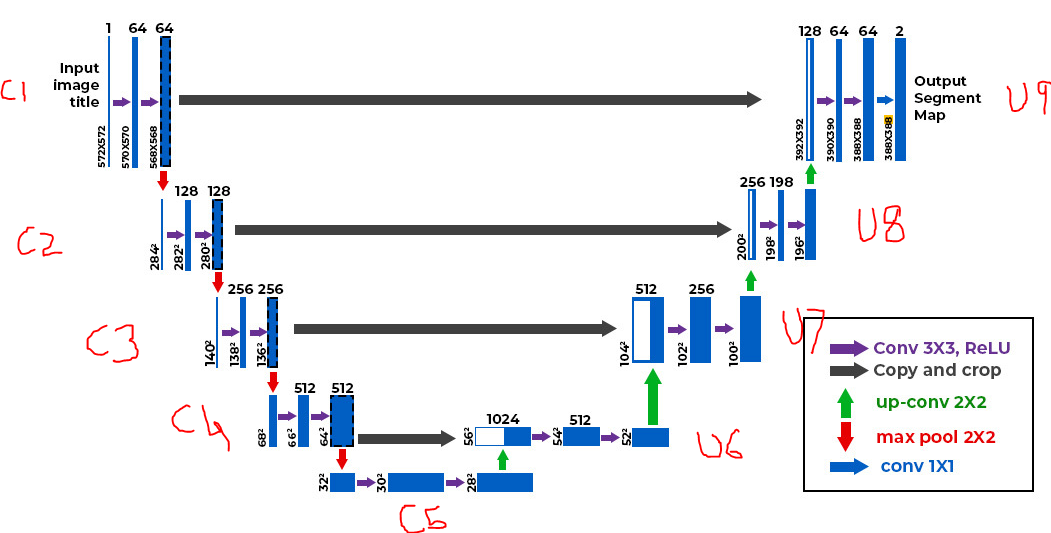

## netron - visualize any deep learning model 
- https://github.com/lutzroeder/netron

In [48]:
def multi_unet_model(n_classes=5,image_height=256,image_width=256,image_channels=1):

    inputs=Input((image_height,image_width,image_channels))
    source_input=inputs
    
    c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(source_input)
    c1=Dropout(0.2)(c1)
    c1=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
    p1=MaxPooling2D((2,2))(c1)

    c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
    c2=Dropout(0.2)(c2)
    c2=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
    p2=MaxPooling2D((2,2))(c2)

    c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
    c3=Dropout(0.2)(c3)
    c3=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
    p3=MaxPooling2D((2,2))(c3)

    c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
    c4=Dropout(0.2)(c4)
    c4=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
    p4=MaxPooling2D((2,2))(c4)

    c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
    c5=Dropout(0.2)(c5)
    c5=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)

    u6=Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5)
    u6=concatenate((u6,c4))
    c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
    c6=Dropout(0.2)(c6)
    c6=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

    u7=Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c6)
    u7=concatenate((u7,c3), axis=3)
    c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
    c7=Dropout(0.2)(c7)
    c7=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

    u8=Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c7)
    u8=concatenate((u8,c2))
    c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
    c8=Dropout(0.2)(c8)
    c8=Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

    u9=Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(c8)
    u9=concatenate((u9,c1))
    c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
    c9=Dropout(0.2)(c9)
    c9=Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

    # output
    outputs=Conv2D(n_classes,(1,1),activation='softmax')(c9)
    model=Model(inputs=[inputs], outputs=[outputs])
    return model

In [49]:
metrics=['accuracy',jaccard_coeff]

In [50]:
def get_deep_learning_model():
    return multi_unet_model(
        n_classes=total_classes,
        image_height=image_height,
        image_width=image_width,
        image_channels=image_channels
    )

In [51]:
model=get_deep_learning_model()

In [52]:
model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config': {'name': '

## Loss Function: Focal Loss (Cross Entropy Loss Extension)
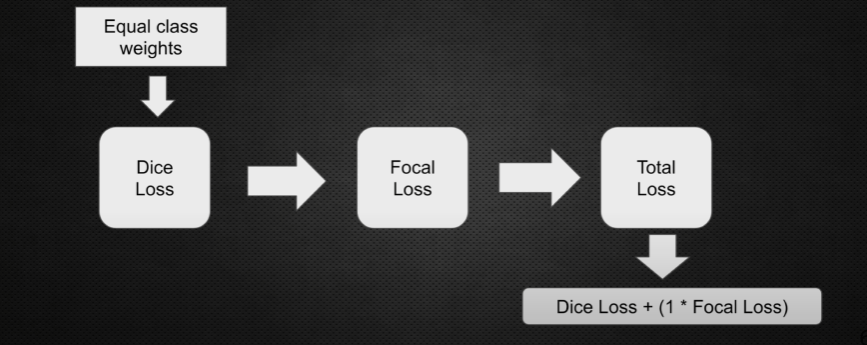

In [53]:
weights = [0.1666,0.1666,0.1666,0.1666,0.1666,0.1666]

# segmentation model
- https://github.com/qubvel/segmentation_models
- loss function to run during training

In [54]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [55]:
dice_loss=sm.losses.DiceLoss(class_weights=weights)
focal_loss=sm.losses.CategoricalFocalLoss()
total_loss=dice_loss+(1*focal_loss)

## model compilation

In [56]:
import tensorflow as tf

In [57]:
tf.keras.backend.clear_session()

In [58]:
model.compile(optimizer='adam',loss=total_loss,metrics=metrics)

In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

##  to plot the model (Visualize)

In [60]:
from keras.utils.vis_utils import plot_model

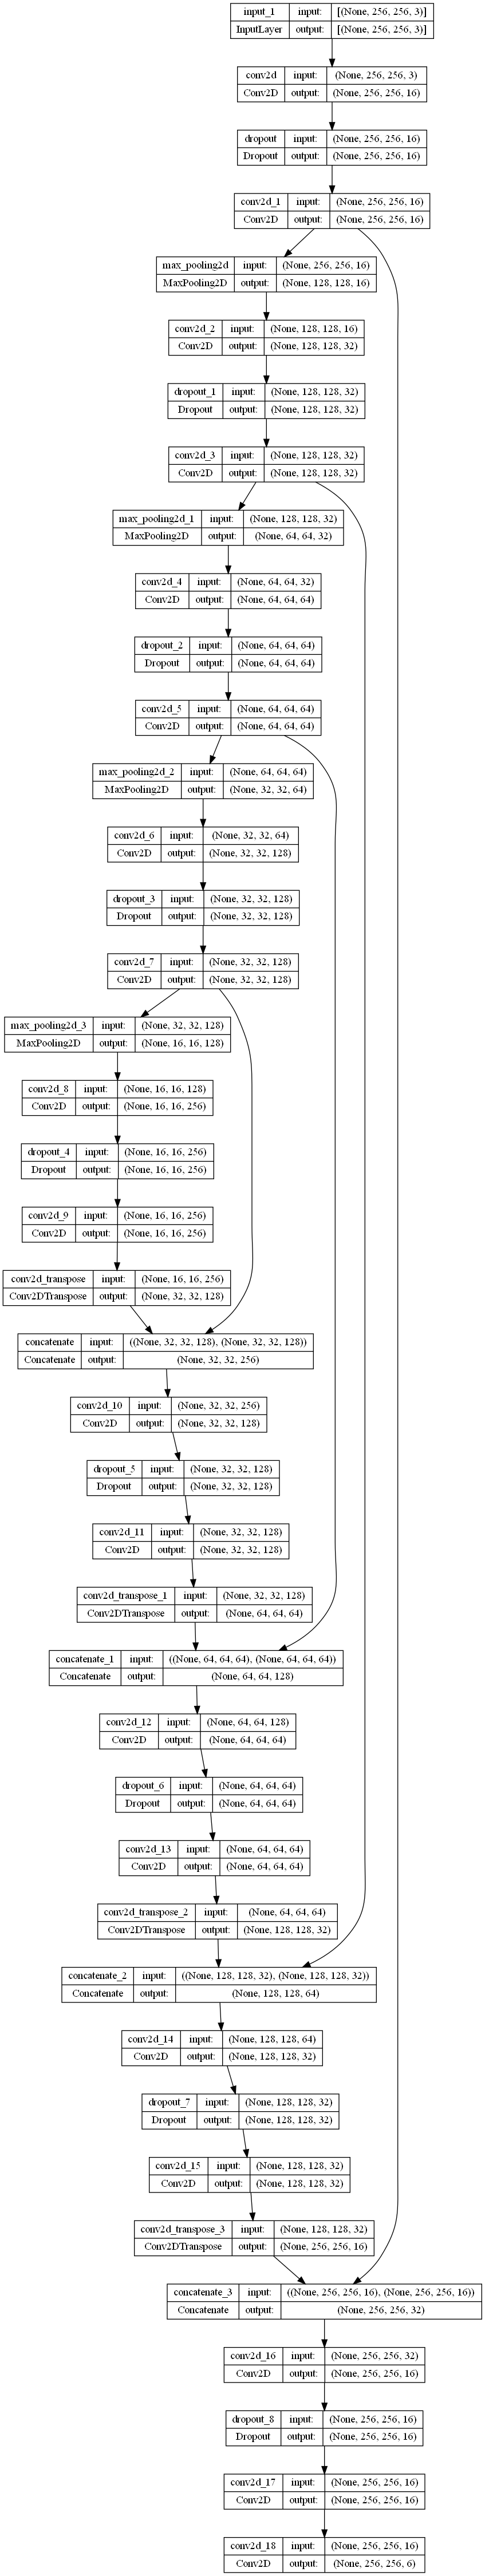

In [61]:
plot_model(model,to_file='satellite_model_plot.png',show_shapes=True,show_layer_names=True)

In [62]:
import keras
from IPython.display import clear_output
%matplotlib inline

In [63]:
class PlotLoss(keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        self.i=0
        self.x=[]
        self.losses=[]
        self.val_losses=[]
        self.jaccard_coef=[]
        self.val_jaccard_coef=[]
        self.fig=plt.figure()
        self.logs=[]
        
    def on_epoch_end(self,epoch,logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.jaccard_coef.append(logs.get('jaccard_coeff'))
        self.val_jaccard_coef.append(logs.get('val_jaccard_coeff'))
        self.i +=1
        
        clear_output(wait=True)

        plt.plot(self.x,self.losses,label='loss')
        plt.plot(self.x,self.val_losses, label='val_loss')
        plt.plot(self.x,self.jaccard_coef,label='jaccard_coeff')
        plt.plot(self.x, self.val_jaccard_coef, label='val_jaccard_coeff')
        plt.legend()
        
        plt.show();

plot_loss=PlotLoss()

In [64]:
class PlotLossEx(keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        self.i=0
        self.x=[]
        self.losses=[]
        self.val_losses=[]
        self.jaccard_coef=[]
        self.val_jaccard_coef=[]
        self.fig=plt.figure()
        self.logs=[]
        
    def on_epoch_end(self,epoch,logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.jaccard_coef.append(logs.get('jaccard_coeff'))
        self.val_jaccard_coef.append(logs.get('val_jaccard_coeff'))
        self.i +=1

        plt.figure(figsize=(14,8))
        f,(graph1,graph2)=plt.subplots(1,2,sharex=True)
        clear_output(wait=True)

        graph1.set_yscale('log')
        graph1.plot(self.x,self.losses,label='loss')
        graph1.plot(self.x, self.val_losses, label='val_loss')
        graph1.legend()

        graph2.set_yscale('log')
        graph2.plot(self.x,self.jaccard_coef,label='jaccard_coeff')
        graph2.plot(self.x, self.val_jaccard_coef, label='val_jaccard_coeff')
        graph2.legend()
        
        plt.show();

plot_loss=PlotLossEx()

## weights and biases callback function for run time diagnostics

In [66]:
import wandb
import os
from wandb.keras import WandbCallback


In [67]:
!wandb login f6696212866a9b097f6468d5cae2901364cf7713
# !export WANDB_INIT_TIMEOUT=120
# os.environ['WANDB_HTTP_TIMEOUT'] = '300'

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Anonymous\_netrc


In [68]:
!wandb status

Current Settings
{
  "_extra_http_headers": null,
  "_proxies": null,
  "api_key": null,
  "base_url": "https://api.wandb.ai",
  "entity": null,
  "git_remote": "origin",
  "ignore_globs": [],
  "project": null,
  "root_dir": null,
  "section": "default"
}


In [69]:
wandb.init(reinit=True,project='satellite-segmentation-dubai-images')


wandb: Currently logged in as: 26-amruth (26-amruth-immortalpi). Use `wandb login --relogin` to force relogin


In [70]:
# wandb.log({'accuracy':jaccard_coef, 'loss':total_loss})

In [71]:
wandb.config.dropout = 0.2

In [72]:
model_history=model.fit(xtrain,ytrain,
                        batch_size=16,
                        verbose=1,
                        epochs=100,
                        validation_data=(xtest,ytest),
                        shuffle=False,
                        # callbacks=[plot_loss] # exernal method for diagnostics local debigging
                        callbacks=[WandbCallback()] #remote debugging
                       )

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 0.9983 - accuracy: 0.5707 - jaccard_coeff: 0.2757

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 23s 296ms/step - loss: 0.9983 - accuracy: 0.5707 - jaccard_coeff: 0.2757 - val_loss: 0.9908 - val_accuracy: 0.6341 - val_jaccard_coeff: 0.3171
Epoch 2/100
50/51 [============================>.] - ETA: 0s - loss: 0.9766 - accuracy: 0.6825 - jaccard_coeff: 0.3829

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 219ms/step - loss: 0.9765 - accuracy: 0.6829 - jaccard_coeff: 0.3855 - val_loss: 0.9671 - val_accuracy: 0.7023 - val_jaccard_coeff: 0.4453
Epoch 3/100
51/51 [==============================] - 6s 115ms/step - loss: 0.9610 - accuracy: 0.7204 - jaccard_coeff: 0.4639 - val_loss: 0.9681 - val_accuracy: 0.6999 - val_jaccard_coeff: 0.4618
Epoch 4/100
51/51 [==============================] - 6s 115ms/step - loss: 0.9531 - accuracy: 0.7431 - jaccard_coeff: 0.4968 - val_loss: 0.9758 - val_accuracy: 0.6791 - val_jaccard_coeff: 0.4572
Epoch 5/100
51/51 [==============================] - 6s 115ms/step - loss: 0.9486 - accuracy: 0.7546 - jaccard_coeff: 0.5202 - val_loss: 0.9697 - val_accuracy: 0.6951 - val_jaccard_coeff: 0.4846
Epoch 6/100
51/51 [==============================] - 6s 119ms/step - loss: 0.9448 - accuracy: 0.7663 - jaccard_coeff: 0.5413 - val_loss: 0.9695 - val_accuracy: 0.6970 - val_jaccard_coeff: 0.4912
Epoch 7/100
50/51 [=================

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 10s 206ms/step - loss: 0.9409 - accuracy: 0.7776 - jaccard_coeff: 0.5648 - val_loss: 0.9585 - val_accuracy: 0.7355 - val_jaccard_coeff: 0.5419
Epoch 8/100
50/51 [============================>.] - ETA: 0s - loss: 0.9348 - accuracy: 0.7964 - jaccard_coeff: 0.5956

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 12s 229ms/step - loss: 0.9348 - accuracy: 0.7968 - jaccard_coeff: 0.5978 - val_loss: 0.9478 - val_accuracy: 0.7722 - val_jaccard_coeff: 0.5820
Epoch 9/100
51/51 [==============================] - 6s 122ms/step - loss: 0.9306 - accuracy: 0.8080 - jaccard_coeff: 0.6194 - val_loss: 0.9493 - val_accuracy: 0.7694 - val_jaccard_coeff: 0.5827
Epoch 10/100
51/51 [==============================] - 6s 125ms/step - loss: 0.9285 - accuracy: 0.8130 - jaccard_coeff: 0.6282 - val_loss: 0.9512 - val_accuracy: 0.7690 - val_jaccard_coeff: 0.5828
Epoch 11/100
50/51 [============================>.] - ETA: 0s - loss: 0.9263 - accuracy: 0.8195 - jaccard_coeff: 0.6363

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 223ms/step - loss: 0.9263 - accuracy: 0.8198 - jaccard_coeff: 0.6389 - val_loss: 0.9371 - val_accuracy: 0.7910 - val_jaccard_coeff: 0.6092
Epoch 12/100
51/51 [==============================] - 6s 124ms/step - loss: 0.9246 - accuracy: 0.8222 - jaccard_coeff: 0.6442 - val_loss: 0.9415 - val_accuracy: 0.7828 - val_jaccard_coeff: 0.5994
Epoch 13/100
51/51 [==============================] - 6s 122ms/step - loss: 0.9229 - accuracy: 0.8279 - jaccard_coeff: 0.6522 - val_loss: 0.9389 - val_accuracy: 0.7865 - val_jaccard_coeff: 0.6097
Epoch 14/100
50/51 [============================>.] - ETA: 0s - loss: 0.9222 - accuracy: 0.8284 - jaccard_coeff: 0.6514

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 216ms/step - loss: 0.9222 - accuracy: 0.8287 - jaccard_coeff: 0.6538 - val_loss: 0.9353 - val_accuracy: 0.7917 - val_jaccard_coeff: 0.6113
Epoch 15/100
50/51 [============================>.] - ETA: 0s - loss: 0.9194 - accuracy: 0.8355 - jaccard_coeff: 0.6639

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 206ms/step - loss: 0.9194 - accuracy: 0.8358 - jaccard_coeff: 0.6666 - val_loss: 0.9316 - val_accuracy: 0.8055 - val_jaccard_coeff: 0.6336
Epoch 16/100
50/51 [============================>.] - ETA: 0s - loss: 0.9187 - accuracy: 0.8368 - jaccard_coeff: 0.6655

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 205ms/step - loss: 0.9188 - accuracy: 0.8371 - jaccard_coeff: 0.6681 - val_loss: 0.9290 - val_accuracy: 0.8101 - val_jaccard_coeff: 0.6373
Epoch 17/100
50/51 [============================>.] - ETA: 0s - loss: 0.9170 - accuracy: 0.8413 - jaccard_coeff: 0.6738

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 10s 202ms/step - loss: 0.9170 - accuracy: 0.8416 - jaccard_coeff: 0.6763 - val_loss: 0.9265 - val_accuracy: 0.8173 - val_jaccard_coeff: 0.6476
Epoch 18/100
50/51 [============================>.] - ETA: 0s - loss: 0.9163 - accuracy: 0.8424 - jaccard_coeff: 0.6749

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 10s 199ms/step - loss: 0.9163 - accuracy: 0.8427 - jaccard_coeff: 0.6776 - val_loss: 0.9246 - val_accuracy: 0.8232 - val_jaccard_coeff: 0.6566
Epoch 19/100
50/51 [============================>.] - ETA: 0s - loss: 0.9148 - accuracy: 0.8464 - jaccard_coeff: 0.6814

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 204ms/step - loss: 0.9149 - accuracy: 0.8467 - jaccard_coeff: 0.6840 - val_loss: 0.9236 - val_accuracy: 0.8242 - val_jaccard_coeff: 0.6561
Epoch 20/100
51/51 [==============================] - 6s 115ms/step - loss: 0.9145 - accuracy: 0.8478 - jaccard_coeff: 0.6861 - val_loss: 0.9259 - val_accuracy: 0.8182 - val_jaccard_coeff: 0.6485
Epoch 21/100
50/51 [============================>.] - ETA: 0s - loss: 0.9146 - accuracy: 0.8470 - jaccard_coeff: 0.6816

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 10s 199ms/step - loss: 0.9147 - accuracy: 0.8473 - jaccard_coeff: 0.6842 - val_loss: 0.9222 - val_accuracy: 0.8248 - val_jaccard_coeff: 0.6583
Epoch 22/100
50/51 [============================>.] - ETA: 0s - loss: 0.9121 - accuracy: 0.8542 - jaccard_coeff: 0.6950

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 10s 203ms/step - loss: 0.9121 - accuracy: 0.8545 - jaccard_coeff: 0.6974 - val_loss: 0.9179 - val_accuracy: 0.8357 - val_jaccard_coeff: 0.6730
Epoch 23/100
51/51 [==============================] - 6s 115ms/step - loss: 0.9119 - accuracy: 0.8544 - jaccard_coeff: 0.6969 - val_loss: 0.9255 - val_accuracy: 0.8231 - val_jaccard_coeff: 0.6569
Epoch 24/100
51/51 [==============================] - 6s 116ms/step - loss: 0.9140 - accuracy: 0.8492 - jaccard_coeff: 0.6871 - val_loss: 0.9253 - val_accuracy: 0.8167 - val_jaccard_coeff: 0.6463
Epoch 25/100
51/51 [==============================] - 6s 116ms/step - loss: 0.9109 - accuracy: 0.8573 - jaccard_coeff: 0.7022 - val_loss: 0.9236 - val_accuracy: 0.8253 - val_jaccard_coeff: 0.6648
Epoch 26/100
51/51 [==============================] - 6s 116ms/step - loss: 0.9102 - accuracy: 0.8586 - jaccard_coeff: 0.7031 - val_loss: 0.9195 - val_accuracy: 0.8352 - val_jaccard_coeff: 0.6754
Epoch 27/100
51/51 [============

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 12s 232ms/step - loss: 0.9073 - accuracy: 0.8667 - jaccard_coeff: 0.7174 - val_loss: 0.9177 - val_accuracy: 0.8431 - val_jaccard_coeff: 0.6885
Epoch 40/100
51/51 [==============================] - 6s 116ms/step - loss: 0.9035 - accuracy: 0.8764 - jaccard_coeff: 0.7326 - val_loss: 0.9180 - val_accuracy: 0.8459 - val_jaccard_coeff: 0.6976
Epoch 41/100
51/51 [==============================] - 6s 116ms/step - loss: 0.9027 - accuracy: 0.8781 - jaccard_coeff: 0.7353 - val_loss: 0.9178 - val_accuracy: 0.8437 - val_jaccard_coeff: 0.6929
Epoch 42/100
51/51 [==============================] - 6s 116ms/step - loss: 0.9015 - accuracy: 0.8816 - jaccard_coeff: 0.7409 - val_loss: 0.9191 - val_accuracy: 0.8436 - val_jaccard_coeff: 0.6945
Epoch 43/100
51/51 [==============================] - 6s 117ms/step - loss: 0.9000 - accuracy: 0.8847 - jaccard_coeff: 0.7479 - val_loss: 0.9213 - val_accuracy: 0.8325 - val_jaccard_coeff: 0.6820
Epoch 44/100
51/51 [============

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 10s 199ms/step - loss: 0.9010 - accuracy: 0.8812 - jaccard_coeff: 0.7423 - val_loss: 0.9144 - val_accuracy: 0.8507 - val_jaccard_coeff: 0.7109
Epoch 47/100
51/51 [==============================] - 6s 116ms/step - loss: 0.8976 - accuracy: 0.8878 - jaccard_coeff: 0.7603 - val_loss: 0.9172 - val_accuracy: 0.8461 - val_jaccard_coeff: 0.7107
Epoch 48/100
50/51 [============================>.] - ETA: 0s - loss: 0.8958 - accuracy: 0.8904 - jaccard_coeff: 0.7672

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 10s 206ms/step - loss: 0.8959 - accuracy: 0.8906 - jaccard_coeff: 0.7691 - val_loss: 0.9142 - val_accuracy: 0.8520 - val_jaccard_coeff: 0.7166
Epoch 49/100
51/51 [==============================] - 6s 116ms/step - loss: 0.8951 - accuracy: 0.8931 - jaccard_coeff: 0.7752 - val_loss: 0.9227 - val_accuracy: 0.8360 - val_jaccard_coeff: 0.6990
Epoch 50/100
51/51 [==============================] - 6s 116ms/step - loss: 0.9000 - accuracy: 0.8808 - jaccard_coeff: 0.7536 - val_loss: 0.9162 - val_accuracy: 0.8449 - val_jaccard_coeff: 0.7064
Epoch 51/100
50/51 [============================>.] - ETA: 0s - loss: 0.8970 - accuracy: 0.8862 - jaccard_coeff: 0.7615

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 10s 201ms/step - loss: 0.8970 - accuracy: 0.8864 - jaccard_coeff: 0.7637 - val_loss: 0.9118 - val_accuracy: 0.8540 - val_jaccard_coeff: 0.7190
Epoch 52/100
51/51 [==============================] - 6s 119ms/step - loss: 0.8971 - accuracy: 0.8850 - jaccard_coeff: 0.7607 - val_loss: 0.9144 - val_accuracy: 0.8513 - val_jaccard_coeff: 0.7173
Epoch 53/100
51/51 [==============================] - 6s 120ms/step - loss: 0.8975 - accuracy: 0.8837 - jaccard_coeff: 0.7594 - val_loss: 0.9244 - val_accuracy: 0.8228 - val_jaccard_coeff: 0.6715
Epoch 54/100
50/51 [============================>.] - ETA: 0s - loss: 0.8985 - accuracy: 0.8807 - jaccard_coeff: 0.7508

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 10s 199ms/step - loss: 0.8986 - accuracy: 0.8809 - jaccard_coeff: 0.7531 - val_loss: 0.9118 - val_accuracy: 0.8493 - val_jaccard_coeff: 0.7104
Epoch 55/100
51/51 [==============================] - 6s 118ms/step - loss: 0.8958 - accuracy: 0.8854 - jaccard_coeff: 0.7610 - val_loss: 0.9119 - val_accuracy: 0.8560 - val_jaccard_coeff: 0.7282
Epoch 56/100
50/51 [============================>.] - ETA: 0s - loss: 0.8951 - accuracy: 0.8867 - jaccard_coeff: 0.7616

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 210ms/step - loss: 0.8952 - accuracy: 0.8870 - jaccard_coeff: 0.7635 - val_loss: 0.9100 - val_accuracy: 0.8537 - val_jaccard_coeff: 0.7179
Epoch 57/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8942 - accuracy: 0.8897 - jaccard_coeff: 0.7675 - val_loss: 0.9125 - val_accuracy: 0.8563 - val_jaccard_coeff: 0.7300
Epoch 58/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8927 - accuracy: 0.8878 - jaccard_coeff: 0.7663 - val_loss: 0.9131 - val_accuracy: 0.8533 - val_jaccard_coeff: 0.7208
Epoch 59/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8925 - accuracy: 0.8907 - jaccard_coeff: 0.7699 - val_loss: 0.9135 - val_accuracy: 0.8548 - val_jaccard_coeff: 0.7257
Epoch 60/100
50/51 [============================>.] - ETA: 0s - loss: 0.8926 - accuracy: 0.8903 - jaccard_coeff: 0.7692

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 209ms/step - loss: 0.8927 - accuracy: 0.8905 - jaccard_coeff: 0.7714 - val_loss: 0.9092 - val_accuracy: 0.8604 - val_jaccard_coeff: 0.7330
Epoch 61/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8936 - accuracy: 0.8853 - jaccard_coeff: 0.7614 - val_loss: 0.9198 - val_accuracy: 0.8357 - val_jaccard_coeff: 0.6963
Epoch 62/100
51/51 [==============================] - 6s 119ms/step - loss: 0.8937 - accuracy: 0.8855 - jaccard_coeff: 0.7606 - val_loss: 0.9166 - val_accuracy: 0.8453 - val_jaccard_coeff: 0.7121
Epoch 63/100
51/51 [==============================] - 6s 119ms/step - loss: 0.8877 - accuracy: 0.8952 - jaccard_coeff: 0.7787 - val_loss: 0.9112 - val_accuracy: 0.8576 - val_jaccard_coeff: 0.7315
Epoch 64/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8912 - accuracy: 0.8910 - jaccard_coeff: 0.7710 - val_loss: 0.9173 - val_accuracy: 0.8366 - val_jaccard_coeff: 0.6971
Epoch 65/100
50/51 [============

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 10s 203ms/step - loss: 0.8882 - accuracy: 0.8944 - jaccard_coeff: 0.7778 - val_loss: 0.9089 - val_accuracy: 0.8646 - val_jaccard_coeff: 0.7427
Epoch 66/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8898 - accuracy: 0.8935 - jaccard_coeff: 0.7755 - val_loss: 0.9142 - val_accuracy: 0.8545 - val_jaccard_coeff: 0.7252
Epoch 67/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8852 - accuracy: 0.8993 - jaccard_coeff: 0.7867 - val_loss: 0.9116 - val_accuracy: 0.8613 - val_jaccard_coeff: 0.7356
Epoch 68/100
51/51 [==============================] - 6s 119ms/step - loss: 0.8853 - accuracy: 0.8994 - jaccard_coeff: 0.7873 - val_loss: 0.9122 - val_accuracy: 0.8584 - val_jaccard_coeff: 0.7287
Epoch 69/100
51/51 [==============================] - 6s 121ms/step - loss: 0.8833 - accuracy: 0.9013 - jaccard_coeff: 0.7905 - val_loss: 0.9134 - val_accuracy: 0.8572 - val_jaccard_coeff: 0.7302
Epoch 70/100
51/51 [============

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 217ms/step - loss: 0.8869 - accuracy: 0.8959 - jaccard_coeff: 0.7804 - val_loss: 0.9085 - val_accuracy: 0.8650 - val_jaccard_coeff: 0.7355
Epoch 75/100
50/51 [============================>.] - ETA: 0s - loss: 0.8826 - accuracy: 0.9030 - jaccard_coeff: 0.7915

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 11s 209ms/step - loss: 0.8827 - accuracy: 0.9032 - jaccard_coeff: 0.7936 - val_loss: 0.9084 - val_accuracy: 0.8659 - val_jaccard_coeff: 0.7453
Epoch 76/100
51/51 [==============================] - 6s 116ms/step - loss: 0.8813 - accuracy: 0.9062 - jaccard_coeff: 0.8002 - val_loss: 0.9122 - val_accuracy: 0.8571 - val_jaccard_coeff: 0.7288
Epoch 77/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8837 - accuracy: 0.9033 - jaccard_coeff: 0.7945 - val_loss: 0.9085 - val_accuracy: 0.8654 - val_jaccard_coeff: 0.7409
Epoch 78/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8815 - accuracy: 0.9053 - jaccard_coeff: 0.7974 - val_loss: 0.9123 - val_accuracy: 0.8604 - val_jaccard_coeff: 0.7371
Epoch 79/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8796 - accuracy: 0.9079 - jaccard_coeff: 0.8032 - val_loss: 0.9142 - val_accuracy: 0.8550 - val_jaccard_coeff: 0.7285
Epoch 80/100
51/51 [============

INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets


INFO:tensorflow:Assets written to: E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best\assets
wandb: Adding directory to artifact (E:\python\python_projects\DeepLearningForSatelliteImagery\wandb\run-20240728_130830-9s01g5ul\files\model-best)... Done. 0.1s


51/51 [==============================] - 10s 203ms/step - loss: 0.8793 - accuracy: 0.9099 - jaccard_coeff: 0.8072 - val_loss: 0.9067 - val_accuracy: 0.8649 - val_jaccard_coeff: 0.7442
Epoch 83/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8802 - accuracy: 0.9091 - jaccard_coeff: 0.8059 - val_loss: 0.9151 - val_accuracy: 0.8517 - val_jaccard_coeff: 0.7229
Epoch 84/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8843 - accuracy: 0.9035 - jaccard_coeff: 0.7948 - val_loss: 0.9128 - val_accuracy: 0.8616 - val_jaccard_coeff: 0.7423
Epoch 85/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8829 - accuracy: 0.9045 - jaccard_coeff: 0.7947 - val_loss: 0.9085 - val_accuracy: 0.8626 - val_jaccard_coeff: 0.7427
Epoch 86/100
51/51 [==============================] - 6s 117ms/step - loss: 0.8781 - accuracy: 0.9135 - jaccard_coeff: 0.8146 - val_loss: 0.9124 - val_accuracy: 0.8581 - val_jaccard_coeff: 0.7352
Epoch 87/100
51/51 [============

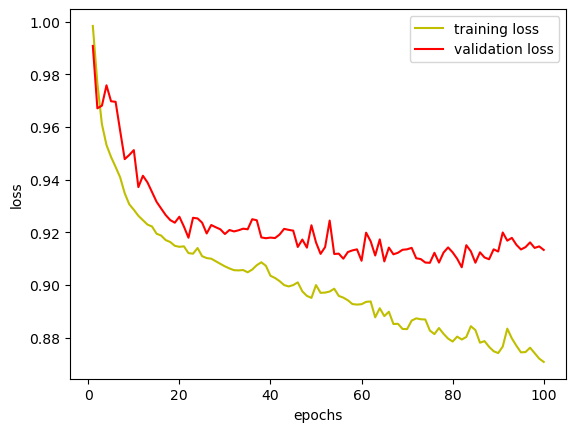

In [73]:
history_a=model_history
loss=history_a.history['loss']
val_loss=history_a.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='training loss')
plt.plot(epochs,val_loss,'r',label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [74]:
# history_a.history

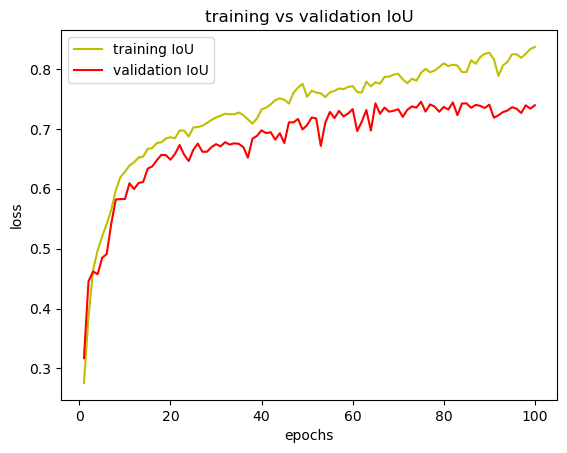

In [75]:
jaccard_coef=history_a.history['jaccard_coeff']
val_jaccard_coef=history_a.history['val_jaccard_coeff']
epochs=range(1,len(jaccard_coef)+1)
plt.plot(epochs,jaccard_coef,'y',label='training IoU')
plt.plot(epochs,val_jaccard_coef,'r',label='validation IoU')
plt.title('training vs validation IoU')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [76]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 51}

# perform predictions

In [77]:
y_pred=model.predict(xtest)

5/5 [==============================] - 2s 44ms/step


In [78]:
len(y_pred)

142

In [79]:
y_pred_argmax=np.argmax(y_pred,axis=3)

In [80]:
len(y_pred_argmax)

142

In [81]:
y_test_argmax=np.argmax(ytest,axis=3)

In [82]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

# comparing prediction results

In [83]:
test_image_number=random.randint(0,len(xtest))
test_image=xtest[test_image_number]
ground_truth_image=y_test_argmax[test_image_number]

test_image_input=np.expand_dims(test_image,0)

prediction=model.predict(test_image_input)
predicted_image=np.argmax(prediction,axis=3)
predicted_image=predicted_image[0,:,:]

1/1 [==============================] - 0s 409ms/step


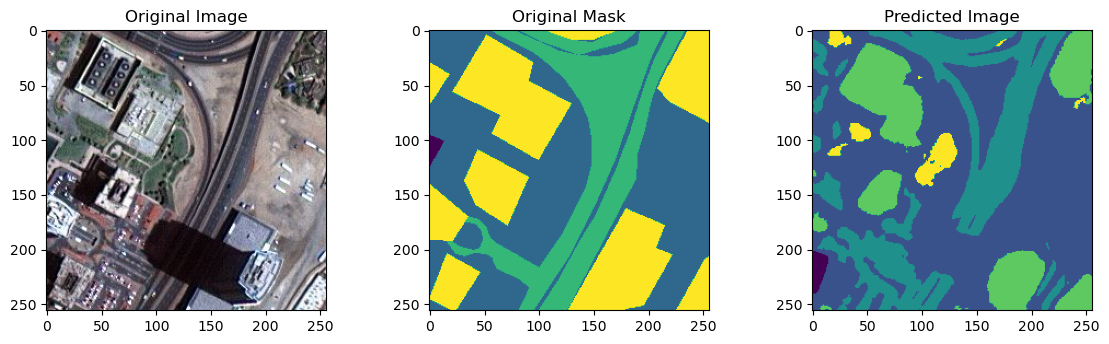

In [84]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title('Original Image')
plt.imshow(test_image)
plt.subplot(232)
plt.title('Original Mask')
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title('Predicted Image')
plt.imshow(predicted_image)

In [85]:
model.save('satellite_segmentation_full.h5')

# can visualize the model using netron by uploading the model
- https://netron.app/

# weights and biases runtime environment

In [ ]:
# !wandb login f6696212866a9b097f6468d5cae2901364cf7713

# Load the saved model to perform prediction

In [86]:
from keras.models import load_model

In [87]:
saved_model=load_model('satellite_segmentation_full.h5',custom_objects=({'dice_loss_plus_1focal_loss':total_loss,'jaccard_coeff':jaccard_coeff}))

In [88]:
model.loss.name

'dice_loss_plus_1focal_loss'

In [89]:
saved_model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 256, 256, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config': {'name': '

In [90]:
test_image_number=random.randint(0,len(xtest))
test_image=xtest[test_image_number]
ground_truth_image=y_test_argmax[test_image_number]

test_image_input=np.expand_dims(test_image,0)

prediction=saved_model.predict(test_image_input)
predicted_image=np.argmax(prediction,axis=3)
predicted_image=predicted_image[0,:,:]

1/1 [==============================] - 0s 188ms/step


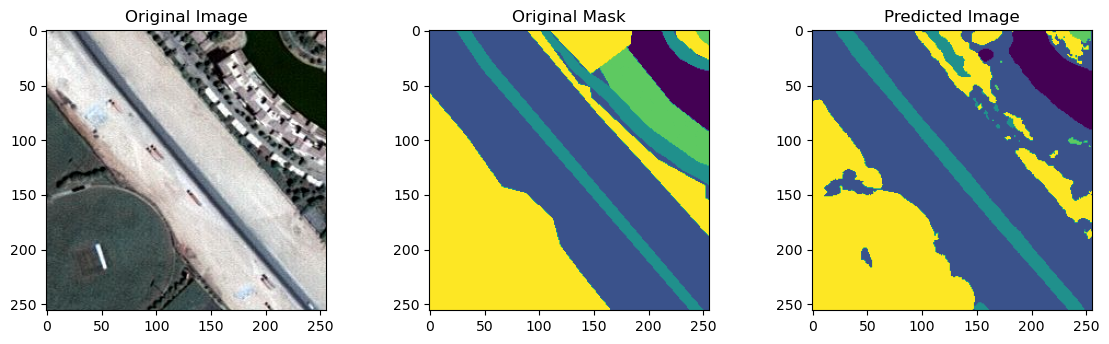

In [91]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title('Original Image')
plt.imshow(test_image)
plt.subplot(232)
plt.title('Original Mask')
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title('Predicted Image')
plt.imshow(predicted_image)

# predict using custom image from Google Map

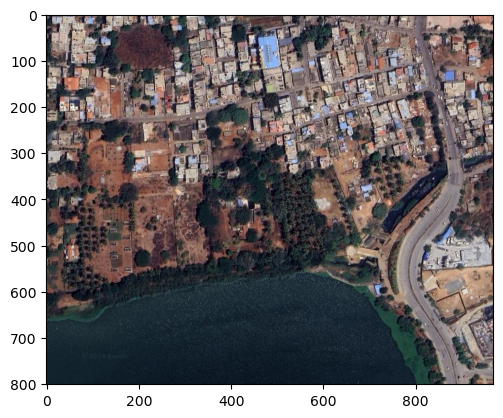

In [92]:
plt.imshow(Image.open('dataset/customImages/1.PNG'))

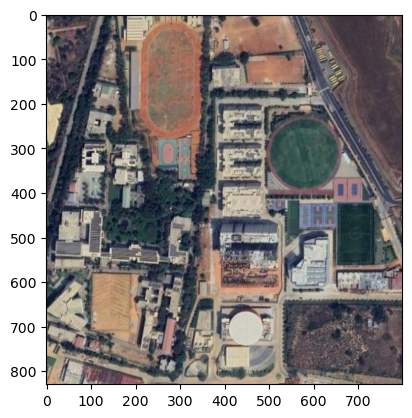

In [93]:
plt.imshow(Image.open('dataset/customImages/3.jpg'))

In [94]:
image=Image.open('dataset/customImages/9.jpg')
if image.mode == 'RGBA':
    image = image.convert('RGB')
image=image.resize((256,256))
# plt.imshow(image)
image=np.array(image)
image=np.expand_dims(image,0)

In [95]:
prediction=saved_model.predict(image)

1/1 [==============================] - 0s 185ms/step


In [96]:
predicted_image=np.argmax(prediction,axis=3)
predicted_image=predicted_image[0,:,:]

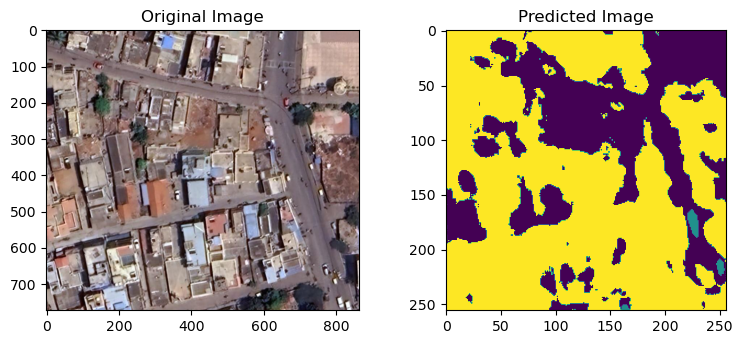

In [100]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title('Original Image')
plt.imshow(Image.open('dataset/customImages/9.jpg'))
plt.subplot(232)
plt.title('Predicted Image')
plt.imshow(predicted_image)

# collecting activation and gradients output from keras model

In [99]:
import keract as ke

In [102]:
activations=ke.get_activations(saved_model,image, nodes_to_evaluate=None, output_format='simple', auto_compile=True)

In [105]:
ke.display_activations(activations,cmap='viridis',save=True,directory='activations')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2

In [110]:
image=Image.open('dataset/customImages/9.jpg')
if image.mode == 'RGBA':
    image = image.convert('RGB')
image=image.resize((256,256))
# plt.imshow(image)
image=np.array(image).astype(np.float32)
ke.display_heatmaps(activations,image, save=True,directory='heatmap')

input_1 (1, 256, 256, 3) 
conv2d (1, 256, 256, 16) 
dropout (1, 256, 256, 16) 
conv2d_1 (1, 256, 256, 16) 
max_pooling2d (1, 128, 128, 16) 
conv2d_2 (1, 128, 128, 32) 
dropout_1 (1, 128, 128, 32) 
conv2d_3 (1, 128, 128, 32) 
max_pooling2d_1 (1, 64, 64, 32) 
conv2d_4 (1, 64, 64, 64) 
dropout_2 (1, 64, 64, 64) 
conv2d_5 (1, 64, 64, 64) 
max_pooling2d_2 (1, 32, 32, 64) 
conv2d_6 (1, 32, 32, 128) 
dropout_3 (1, 32, 32, 128) 
conv2d_7 (1, 32, 32, 128) 
max_pooling2d_3 (1, 16, 16, 128) 
conv2d_8 (1, 16, 16, 256) 
dropout_4 (1, 16, 16, 256) 
conv2d_9 (1, 16, 16, 256) 
conv2d_transpose (1, 32, 32, 128) 
concatenate (1, 32, 32, 256) 
conv2d_10 (1, 32, 32, 128) 
dropout_5 (1, 32, 32, 128) 
conv2d_11 (1, 32, 32, 128) 
conv2d_transpose_1 (1, 64, 64, 64) 
concatenate_1 (1, 64, 64, 128) 
conv2d_12 (1, 64, 64, 64) 
dropout_6 (1, 64, 64, 64) 
conv2d_13 (1, 64, 64, 64) 
conv2d_transpose_2 (1, 128, 128, 32) 
concatenate_2 (1, 128, 128, 64) 
conv2d_14 (1, 128, 128, 32) 
dropout_7 (1, 128, 128, 32) 
conv2